In [1]:
import numpy 
from scipy.io import wavfile
from pathlib import Path
import librosa
import librosa.display
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torcheval.metrics import R2Score
import dawdreamer as daw
import numpy 
from scipy.io import wavfile
from pathlib import Path
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
# Load wav file form disk
audio_path = Path('./samples/preset_0.wav')
audio = wavfile.read(audio_path)[1]

In [3]:
print(audio)

[[-3.0376992e-07 -3.0376992e-07]
 [-2.9948259e-07 -2.9948259e-07]
 [-2.9659986e-07 -2.9659986e-07]
 ...
 [ 2.5042088e-03  2.4785353e-03]
 [ 1.0809554e-03  1.1855987e-03]
 [-3.4654529e-03 -3.5389827e-03]]


In [4]:
def generate_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # display
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.power_to_db(spectrogram, ref=numpy.max), y_axis='mel', x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel spectrogram display')
    plt.show()

    # Save to disk
    print(spectrogram)
    print(spectrogram.shape)

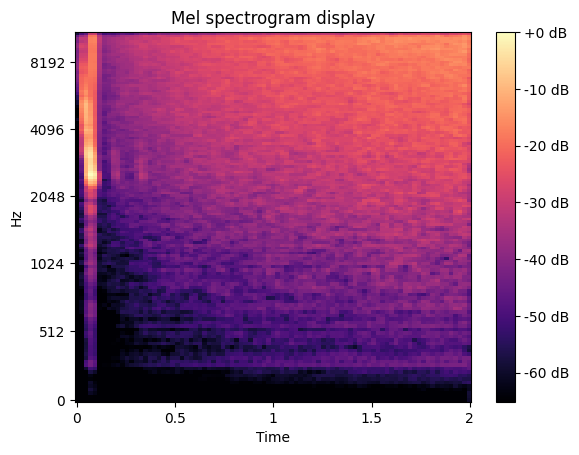

[[1.5877483e-11 5.4954210e-12 5.5588849e-12 ... 7.1741671e-12
  5.0606633e-11 3.4110401e-10]
 [9.6118252e-12 2.6582636e-12 7.1850650e-12 ... 5.6946284e-12
  6.5526126e-11 3.8902001e-10]
 [7.4808874e-12 2.3609951e-12 1.9948654e-11 ... 2.5331093e-11
  1.0441002e-10 4.3301596e-10]
 ...
 [3.2434663e-08 2.4728476e-07 2.6680638e-07 ... 9.0227513e-06
  1.1999635e-05 7.4440886e-06]
 [9.8259330e-09 6.9754236e-08 1.2324074e-07 ... 5.4558441e-06
  1.0147677e-05 5.9585263e-06]
 [5.6760718e-10 4.0344101e-09 1.0014868e-08 ... 8.3537276e-07
  1.1540116e-06 8.1836941e-07]]
(128, 87)


In [5]:
generate_spectrogram(audio_path)

In [19]:
class AudioDS(Dataset):
    def __init__(self, presets_csv_path):
        self.presets = pd.read_csv(presets_csv_path)
    
    def __len__(self):
        return len(self.presets)
    
    def __getitem__(self, idx):
        preset = self.presets.iloc[idx]
        audio_path = Path(f'./samples/{preset[0]}.wav')
        y, sr = librosa.load(audio_path)
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        
        # Save spectrogram image for debugging
        # fig, ax = plt.subplots()
        # img = librosa.display.specshow(librosa.power_to_db(spectrogram, ref=numpy.max), y_axis='mel', x_axis='time', ax=ax)
        # fig.colorbar(img, ax=ax, format='%+2.0f dB')
        # ax.set(title='Mel spectrogram display')
        # # Save to disk
        # # create folder if not exists
        # Path('./sample_images').mkdir(parents=True, exist_ok=True)
        # plt.savefig(f'./sample_images/{preset[0]}.png')

        # Add channel dimension
        spectrogram = numpy.expand_dims(spectrogram, axis=0)
        # Transform to tensors
        spectrogram = torch.tensor(spectrogram)
        preset = torch.tensor(preset[1:-1])

        return spectrogram, preset

In [20]:
dataset = AudioDS('presets.csv')
num_train = int(0.9 * len(dataset))
num_val = len(dataset) - num_train
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [num_train, num_val])
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [21]:
# Basic CNN. Credit: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
class AudioClassifier(nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(128)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        self.conv5 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(256)
        init.kaiming_normal_(self.conv5.weight, a=0.1)
        self.conv5.bias.data.zero_()
        conv_layers += [self.conv5, self.relu5, self.bn5]

        self.conv6 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu6 = nn.ReLU()
        self.bn6 = nn.BatchNorm2d(512)
        init.kaiming_normal_(self.conv6.weight, a=0.1)
        self.conv6.bias.data.zero_()
        conv_layers += [self.conv6, self.relu6, self.bn6]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=512, out_features=1)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device
# print number of parameters
print(sum(p.numel() for p in myModel.parameters() if p.requires_grad))

cuda:0
1575265


In [22]:
def train(model, train_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    # because this is regression, use mse
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
    #                                                 steps_per_epoch=int(len(train_dl)),
    #                                                 epochs=num_epochs,
    #                                                 anneal_strategy='linear')

    num_steps = len(train_dl)
    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        total_r2 = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            # inputs_m, inputs_s = inputs.mean(), inputs.std()
            # inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
        
            outputs.float()
            labels = labels.float()

            # grab the first label for all batches
            labels = labels[:,0].unsqueeze(1)

            # print('inputs: ', inputs)
            # print('inputs shape: ', inputs.shape) # 1, 1, 128, 87
            # print('labels: ', labels) 
            # print('labels shape: ', labels.shape) # 1, 88

            # print('outputs: ', outputs)
            # print('outputs shape: ', outputs.shape) # 1, 10

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # scheduler.step()

            # print('loss: ', loss.item())
            # # Keep stats for Loss and Accuracy
            running_loss += loss.item()
            total_loss += loss.item()

            # Get the predicted class with the highest score
            # _, prediction = torch.max(outputs,1)
            # # Count of predictions that matched the target label
            # correct_prediction += (prediction == labels).sum().item()
            # total_prediction += prediction.shape[0]
            
            # Compute r squared value
            r2 = R2Score()
            r2.update(outputs, labels)
            r2_score = r2.compute().item()
            # print('r2: ', r2.compute())
            # total_r2 += r2.compute()

            if i % 10 == 0:    # print every 10 mini-batches
               print('[epoch: %d, step: %5d of %5d] loss: %.3f, r2: %.3f' % (epoch + 1, i + 1, num_steps, running_loss / 10, r2_score))
               running_loss = 0.0
        
        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = total_loss / num_batches
        # acc = correct_prediction / total_prediction
        # r2 = total_r2 / num_batches
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}')

    print('Finished Training')
  
num_epochs=1
train(myModel, train_loader, num_epochs)

C:\Users\jayor\AppData\Local\Temp\ipykernel_22748\3890456011.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  audio_path = Path(f'./samples/{preset[0]}.wav')
C:\Users\jayor\AppData\Local\Temp\ipykernel_22748\3890456011.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preset = torch.tensor(preset[1:-1])


[epoch: 1, step:     1 of   844] loss: 0.032, r2: -2.480
[epoch: 1, step:    11 of   844] loss: 0.943, r2: -9.827
[epoch: 1, step:    21 of   844] loss: 0.379, r2: -2.748
[epoch: 1, step:    31 of   844] loss: 0.252, r2: -3.014
[epoch: 1, step:    41 of   844] loss: 0.217, r2: -2.988
[epoch: 1, step:    51 of   844] loss: 0.160, r2: -5.368
[epoch: 1, step:    61 of   844] loss: 0.119, r2: -0.700
[epoch: 1, step:    71 of   844] loss: 0.125, r2: -0.373
[epoch: 1, step:    81 of   844] loss: 0.111, r2: -0.193
[epoch: 1, step:    91 of   844] loss: 0.107, r2: -0.382
[epoch: 1, step:   101 of   844] loss: 0.108, r2: -0.272
[epoch: 1, step:   111 of   844] loss: 0.111, r2: -0.089
[epoch: 1, step:   121 of   844] loss: 0.131, r2: -0.410
[epoch: 1, step:   131 of   844] loss: 0.130, r2: -0.735
[epoch: 1, step:   141 of   844] loss: 0.102, r2: -0.545
[epoch: 1, step:   151 of   844] loss: 0.106, r2: -0.096
[epoch: 1, step:   161 of   844] loss: 0.104, r2: -0.118
[epoch: 1, step:   171 of   844

In [ ]:
def validation(model, val_dl):
    criterion = nn.MSELoss()
    # Repeat for each batch in the validation set
    with torch.no_grad():
        running_loss = 0.0
        total_loss = 0.0

        for i, data in enumerate(val_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # forward + backward + optimize
            outputs = model(inputs)
        
            outputs.float()
            labels = labels.float()

            loss = criterion(outputs, labels)

            # # Keep stats for Loss and Accuracy
            running_loss += loss.item()
            total_loss += loss.item()

            
            # Compute r squared value
            r2 = R2Score()
            r2.update(outputs, labels)
            r2_score = r2.compute().item()

            if i % 10 == 0:    # print every 10 mini-batches
               print('[step: %5d] loss: %.3f, r2: %.3f' % (i + 1, running_loss / 10, r2_score))
               running_loss = 0.0
        
validation(myModel, val_loader)

C:\Users\jayor\AppData\Local\Temp\ipykernel_6612\3890456011.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  audio_path = Path(f'./samples/{preset[0]}.wav')
C:\Users\jayor\AppData\Local\Temp\ipykernel_6612\3890456011.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preset = torch.tensor(preset[1:-1])


[step:     1] loss: 0.008, r2: -0.035
[step:    11] loss: 0.084, r2: -0.035
[step:    21] loss: 0.084, r2: -0.045


KeyboardInterrupt: 

In [13]:
def predict(model, preset_name):
    y, sr = librosa.load(f'./samples/{preset_name}.wav')
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # Add channel dimension
    spectrogram = numpy.expand_dims(spectrogram, axis=0)
    # Add batch dimension
    spectrogram = numpy.expand_dims(spectrogram, axis=0)
    # Transform to tensors
    spectrogram = torch.tensor(spectrogram).to(device)
    # Normalize the inputs
    inputs_m, inputs_s = spectrogram.mean(), spectrogram.std()
    spectrogram = (spectrogram - inputs_m) / inputs_s
    print('spectrogram: ', spectrogram)

    # Make prediction
    outputs = model(spectrogram)

    true = pd.read_csv('presets.csv')
    # add column names
    true.columns = ['preset'] + [f'param_{i}' for i in range(89)]
    # Get the true values for the preset
    true = true.loc[true['preset'] == preset_name].values[0][1:-1]
    # convert eachv value to a float
    true = [float(i) for i in true]
    print('true: ', true)

    # remove outputs dimension
    outputs = outputs.squeeze().cpu().detach().numpy()
    print('outputs: ', outputs)
    # Compare difference between true and predicted values
    diff = numpy.subtract(true, outputs)
    print('diff: ', diff)

    # Generate sounds from predicted values
    engine = daw.RenderEngine(44100, 512)
    engine.set_bpm(120.)
    synth = engine.make_plugin_processor("synth", "C:\\Program Files\\Common Files\\VST3\\TAL-NoiseMaker.vst3\\Contents\\x86_64-win\\TAL-NoiseMaker.vst3")
    for i, param in enumerate(outputs):
        synth.set_parameter(i, param)

    synth.add_midi_note(60, 100, 0.0, 5.)
    engine.load_graph([
        (synth, [])
        ])
    engine.render(2.)
    audio = engine.get_audio()

    directory = Path('./predictions/')
    directory.mkdir(parents=True, exist_ok=True)
    
    wavfile.write(directory / (preset_name + '.wav'), 44100, audio.transpose())

In [14]:
predict(myModel, 'preset_1')

spectrogram:  tensor([[[[-0.4015, -0.4015, -0.4015,  ..., -0.3992, -0.3935, -0.3971],
          [-0.4008, -0.4002, -0.4011,  ..., -0.3966, -0.3899, -0.3950],
          [-0.4009, -0.4003, -0.4008,  ..., -0.3922, -0.3791, -0.3766],
          ...,
          [-0.4016, -0.4015, -0.4015,  ..., -0.4005, -0.4007, -0.4007],
          [-0.4016, -0.4016, -0.4015,  ..., -0.4006, -0.4007, -0.4006],
          [-0.4016, -0.4016, -0.4016,  ..., -0.4015, -0.4015, -0.4010]]]],
       device='cuda:0')
true:  [0.5495668527721042, 0.3748470513236892, 0.6196008493884446, 0.3324025770489228, 0.4230844708780227, 0.525686519543937, 0.3637492891941009, 0.4174203191400804, 0.544811494631712, 0.6322071133154097, 0.6172459635028974, 0.6474080410080121, 0.3593742889653164, 0.4972905225622229, 0.9789941596534936, 0.0118836391955273, 0.9551713685988898, 0.5868036138037456, 0.1549335544902369, 0.0055585126194702, 0.2698823475010705, 0.8466922912347506, 0.7233092169703106, 0.8187400908015904, 0.4999780991298799, 0.9968

TypeError: iteration over a 0-d array

In [17]:
predict(myModel, 'preset_6')

spectrogram:  tensor([[[[26.3401, 11.6185, -0.0570,  ..., -0.2019, -0.2019, -0.2019],
          [33.3438, 15.6214, -0.1191,  ..., -0.2019, -0.2019, -0.2019],
          [20.8127,  8.6902, -0.1675,  ..., -0.2019, -0.2019, -0.2019],
          ...,
          [-0.1946, -0.1968, -0.1986,  ..., -0.2011, -0.2010, -0.2014],
          [-0.1916, -0.1925, -0.1971,  ..., -0.2013, -0.2014, -0.2017],
          [-0.2009, -0.2014, -0.2015,  ..., -0.2019, -0.2019, -0.2019]]]],
       device='cuda:0')
true:  [0.7142947616628907, 0.6527805437101899, 0.7626885256516487, 0.8048027015209686, 0.7884369194913219, 0.623060931488248, 0.6182921163510693, 0.0022636322176829, 0.2366209466241292, 0.895783928659829, 0.6265617385499658, 0.0317057322857361, 0.6404674199023089, 0.4096515042294096, 0.7518169001377119, 0.2925734272650162, 0.5703158726134361, 0.7550367136322215, 0.9658456102354755, 0.1692662844181198, 0.9935049021238042, 0.9467484207770974, 0.1925739196041304, 0.2396488750274779, 0.3322104962117268, 0.4154

TypeError: iteration over a 0-d array